In [65]:
import pandas as pd
import numpy as np
import itertools
import scipy
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
%pylab inline
data = pd.read_csv('/content/sample_data/credit_card_default_analysis.csv',index_col=['ID'])
data.head()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['chisquare']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?


LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)

In [3]:
group_default_0 = data[data['default']==0].LIMIT_BAL
group_default_1 = data[data['default']==1].LIMIT_BAL

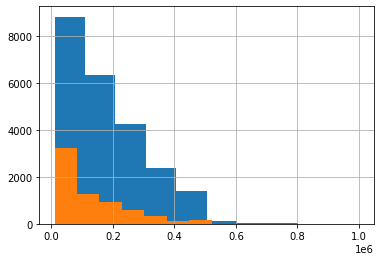

In [4]:
group_default_0.hist()
group_default_1.hist()

H0 : medX1 = medX2

H1 : medX1 != medX2

a) Проверяем гипотезу о равенстве медианных значений с помощью интервальной оценки. Доверительный интервал будем строить на основе бутстрэпа. Для  начала приведем точечную оценку разности медиан:


In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
print('Точечная оценка разности медиан = ', np.median(group_default_0) - np.median(group_default_1))

Точечная оценка разности медиан =  60000.0


Получим бутсрэпом наши выборки:

In [7]:
default0_median_scores = map(np.median, get_bootstrap_samples(group_default_0.values, 10000))
default1_median_scores = map(np.median, get_bootstrap_samples(group_default_1.values, 10000))

Строим 95% доверительный интервал:

In [8]:
delta_median_scores = map(lambda x: x[0] - x[1], zip(default0_median_scores, default1_median_scores))

In [9]:
print("95% confidence interval for the difference between medians",  stat_intervals(list(delta_median_scores), 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


Видим,что 0 не содержится в этом интервале, следовательно мы можем сделать вывод, что нулевая гипотеза отклоняется. Чтобы удостоверитсья в этом можно посчитать p_value: который равен наибольшему значению alpha, при котором интервал захватывает 0. Практически, двигая alpha установилось что правый конец ниже порога 60000 не идет

Теперь хотим проверить гипотезу о равенстве распределений с помощью перестановочного критерия для независимых выборок:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
      np.random.shuffle(index)
      indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

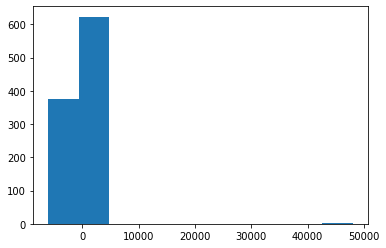

In [11]:
pylab.hist(permutation_zero_dist_ind(group_default_0.values, group_default_1.values, max_combinations = 1000))
pylab.show()

In [12]:
print("p-value: %f" % permutation_test(group_default_0, group_default_1, max_permutations = 10000))

p-value: 0.000100


p_value < 0.05. Следовательно, нулевую гипотезу на уровне значимости 0.05 мы отвергаем

2. Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [15]:
group_default_0 = data[data['default']==0]['SEX'].apply(lambda x: 0 if x==1 else 1)
group_default_1 = data[data['default']==1]['SEX'].apply(lambda x: 0 if x==1 else 1)

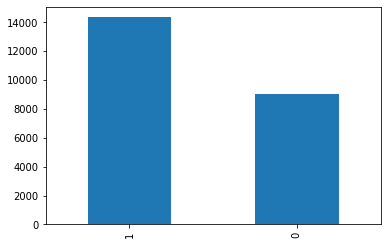

In [21]:
group_default_0.value_counts().plot(kind='bar')

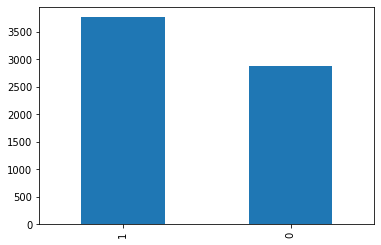

In [22]:
group_default_1.value_counts().plot(kind='bar')

Построим доверительные интервалы для долей мужчин и женщин в выборке тех, кто вернул кредит и тех, кто не вернули кредит

In [38]:
proportion_confint(sum(group_default_0), len(group_default_0), method = 'wilson')

(0.607889734030124, 0.6203726841910749)

In [40]:
proportion_confint(sum(group_default_1), len(group_default_1), method = 'wilson')

(0.5551017630282817, 0.578937581965066)

Как видно из интервальных оценок, сами интервалы не пересекаются, следовательно гендерный состав различается.

Применим z-критерий о равенстве двух долей и построим доверительный интервал для разности долей:

In [33]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [34]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(group_default_0, group_default_1))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


In [35]:
print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(group_default_0, group_default_1)))

p-value:  4.472866521609831e-12


Видим, что доверительный интервал не захватывает 0 и значение p_value< 0.05. Следовательно, гипотезу о равенстве долей можно отвергнуть

3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

In [41]:
group_default_0 = data[data['default']==0].EDUCATION
group_default_1 = data[data['default']==1].EDUCATION

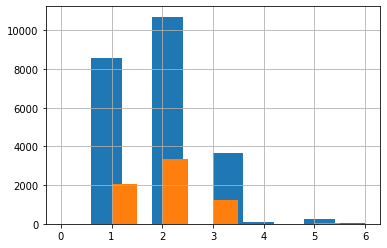

In [42]:
group_default_0.hist()
group_default_1.hist()

По гистограмме видно, что если мы выкинем 0,4,5,6, то не потеряем в интепретируемости

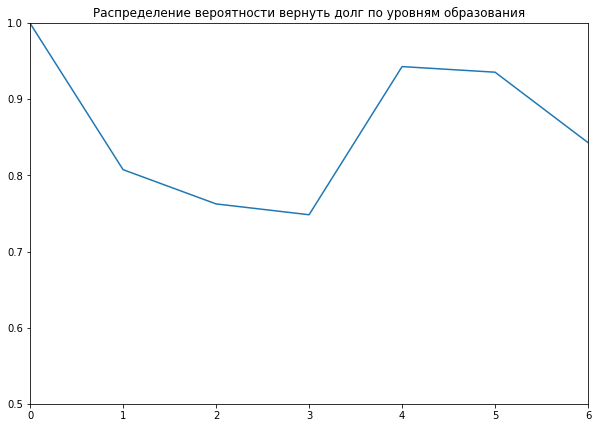

In [81]:

education = data.EDUCATION
education_prop = np.empty((len(np.unique(group_default_0)), 2))
for i, val in enumerate(np.unique(education)):
    education_prop[i, 0] = val
    education_prop[i, 1] = group_default_0[group_default_0 == val].shape[0] / (group_default_0[group_default_0 == val].shape[0] + group_default_1[group_default_1 == val].shape[0])



plt.figure(1, figsize=(10,7))
plt.title('Распределение вероятности вернуть долг по уровням образования')
plt.plot(education_prop[:,0], education_prop[:,1])
plt.axis([0, 6, 0.5, 1])
plt.show()

Видим, что хуже всего долг возвращают бакалавры и выпускники школ. А вот доктора наук долг возвращают всегда

Хотим проверить гипотезу о том, что столбцы EDUCATION и default независимы, для этого воспользуемся критерием хи-квадрат. Проверим значимость отличия от нуля коэффициента V Крамера

Составим таблицу сопряжённости "образование" на "возврат долга", где в ячейке будет стоять количество людей в данных категориях

In [74]:
edu_num_0 = np.array([group_default_0[group_default_0 == ed_val].shape[0] for ed_val in range(7)])
edu_num_1 = np.array([group_default_1[group_default_1 == ed_val].shape[0] for ed_val in range(7)])
edu_num = edu_num_0 + edu_num_1


d = {'default_0':[],'default_1':[]}
for i in range(7):
    d['default_0'].append(edu_num_0[i])
    d['default_1'].append(edu_num_1[i])
    print('Edu lvl %d: %d / %d | %d' % (i, edu_num_0[i], edu_num_1[i], edu_num[i]))
print('Legend: deafault = 0 / default = 1 | total')
dataframe_contingency = pd.DataFrame(data = d)

Edu lvl 0: 14 / 0 | 14
Edu lvl 1: 8549 / 2036 | 10585
Edu lvl 2: 10700 / 3330 | 14030
Edu lvl 3: 3680 / 1237 | 4917
Edu lvl 4: 116 / 7 | 123
Edu lvl 5: 262 / 18 | 280
Edu lvl 6: 43 / 8 | 51
Legend: deafault = 0 / default = 1 | total


Составим таблицу сопряжённости "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

In [75]:
prop_mean = education_prop[:,1].mean()
edu_num_0 = np.array([group_default_0[group_default_0 == ed_val].shape[0] for ed_val in range(7)])
edu_num_1 = np.array([group_default_1[group_default_1 == ed_val].shape[0] for ed_val in range(7)])
edu_num = edu_num_0 + edu_num_1
exp_freq = np.array([prop_mean * edu_num[i] for i in range(7)])
print('Legend: exp freq / obs freq = 1 | delta')
for i in range(7):
    print('Edu lvl %d: %d / %d | %d' % (i, exp_freq[i], edu_num_0[i], edu_num_0[i] - exp_freq[i]))



Legend: exp freq / obs freq = 1 | delta
Edu lvl 0: 12 / 14 | 1
Edu lvl 1: 9134 / 8549 | -585
Edu lvl 2: 12107 / 10700 | -1407
Edu lvl 3: 4243 / 3680 | -563
Edu lvl 4: 106 / 116 | 9
Edu lvl 5: 241 / 262 | 20
Edu lvl 6: 44 / 43 | -1


In [83]:
p_val = chi2_contingency(dataframe_contingency)[1]
print('p_value =',p_val)

p_value = 1.2332626245415605e-32


Видим, что на уровне значимости 0.05 нулевая гипотеза о независимости выборок отвергается.      Результат имеет практическую значимость для выдачи кредита, доли возврата значимо отличаются для разных уровней образования.

4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [88]:
group_default_0 = data[data['default']==0].MARRIAGE
group_default_1 = data[data['default']==1].MARRIAGE

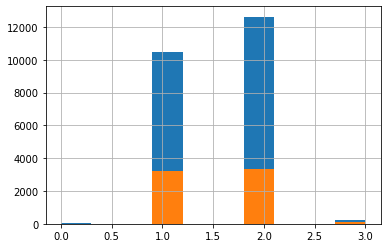

In [89]:
group_default_0.hist()
group_default_1.hist()

Посчитаем коэффициент V Крамера для семейного статуса и индикатора дефолта. Вытащим статистику из chi2_contingency и посчитаем по формуле. Перед этим собирем таблицу сопряженности:

In [97]:
mar = data.MARRIAGE
conf_table = np.empty( (len(mar.value_counts()), 2) )
for i in range(len(mar.value_counts())):
    conf_table[i, 0] = len(group_default_0.loc[group_default_0 == i])
    conf_table[i, 1] = len(group_default_1.loc[group_default_1 == i])
pd.DataFrame(conf_table)

,0,1
0,49.0,5.0
1,10453.0,3206.0
2,12623.0,3341.0
3,239.0,84.0


In [95]:
def cramers_stat(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [96]:
print('V Cramer stat value: %.4f' % cramers_stat(conf_table))

V Cramer stat value: 0.0345


Видим, что коэффициент V Крамера близок к нулю, когда взаимосвязь отсутствует

5. Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [98]:
group_default_0 = data[data['default']==0].AGE
group_default_1 = data[data['default']==1].AGE

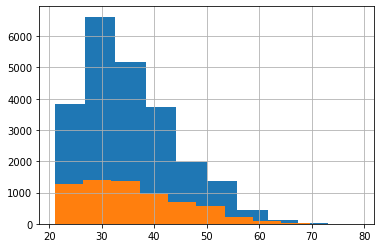

In [99]:
group_default_0.hist()
group_default_1.hist()

Построим 95% доверительный интвервал, сначала получим бутстрэпом наши выборки.

In [113]:
default0_median_scores = map(np.median, get_bootstrap_samples(group_default_0.values, 10000))
default1_median_scores = map(np.median, get_bootstrap_samples(group_default_1.values, 10000))

In [114]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(default0_median_scores, default1_median_scores))

In [115]:
print("95% confidence interval for the difference between medians",  stat_intervals(list(delta_median_scores), 0.05))

95% confidence interval for the difference between medians [0. 1.]


Так как доверительный интервал содержит 0, то медианы не различаются

In [116]:
print("p-value: %f" % permutation_test(group_default_1, group_default_0, max_permutations = 10000))

p-value: 0.015600


p_val<0.05 и гипотезу о равенстве распределений мы отвергаем

Результат является практически значимым, потому что разница в распределениях видна невооружённым взглядом и эти данные могут учитываться при выдаче кредита